# YouTube Data API v3 - Mapping Corridor Digital's Network

### Python Libraries

In [1]:
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

## Custom modules

In [2]:
#import config # api_key is stored in config.py
import youtube_requests # Functions for making youtube_requests
import data_processing # Functions for data processing    
import network_graphs # Functions for creating a network graph

Run autoloader to automatically reimport custom modules

In [3]:
%load_ext autoreload

%autoreload 1

%aimport network_graphs
%aimport youtube_requests
%aimport data_processing

## Create a list of channels to graph network

Here we are graphing Corridor, Corridor Crew, Corridor Cast, Node, and the Guilletine Channel. These are all channels related to the [Corridor Digital](https://www.youtube.com/user/CorridorDigital) production studio.

In [4]:
CORRIDOR_FIVE = ['UCNSeDrWRGxx5p2l3tj7RWQw',
                'UCsn6cjffsvyOZCZxvGoJxGg',
                'UCSpFnDQr88xCZ80N-X7t0nQ',
                'UCI4Wh0EQPjGx2jJLjmTsFBQ',
                'UCb8ewylk7d2M_1dLGEiFmuQ']

# Youtube Channel Details by Network

In [5]:
%%time
# Get a list of dictionaries, where each dictionary represents details for a specific channel
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_network(CORRIDOR_FIVE, 3)

# Graph the network of channels
G = network_graphs.create_nx_graph(CHANNELS_DETAILS_ITEMS_LIST, True)

# Extract a columnar list of channel details
CHANNELS_DETAILS_LIST = data_processing.extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Create a dataframe
DF = data_processing.create_df_from_details_list(CHANNELS_DETAILS_LIST)

# Graph G using matplotlib - gets messy with lots of data
#network_graphs.graph_nx_graph(G)

Havent seen this list, request and cache
25 total neighbors; 0 out of 5 channels do not feature channels
97 total neighbors; 2 out of 20 channels do not feature channels
253 total neighbors; 11 out of 86 channels do not feature channels
CPU times: user 25.5 s, sys: 1.91 s, total: 27.4 s
Wall time: 57.4 s


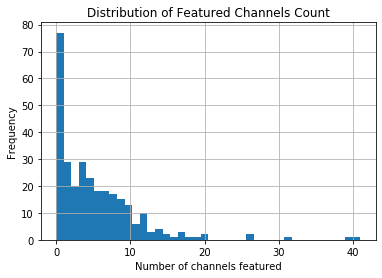

In [6]:
DF.hist(column='featuredChannelsCount', bins=40)
plt.title(label='Distribution of Featured Channels Count')
plt.xlabel(xlabel='Number of channels featured')
plt.ylabel(ylabel='Frequency');

Here we see most channels do not feature more than 10 other channels on their profile pages. Some feature a lot more, with one as an outlier featuring 40 other channels.

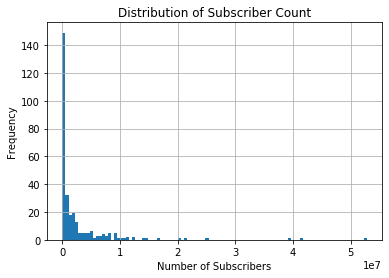

In [7]:
DF.hist(column = 'subscriberCount', bins=100)
plt.title(label='Distribution of Subscriber Count')
plt.xlabel(xlabel='Number of Subscribers')
plt.ylabel(ylabel='Frequency');

Here we see that the distribution of subscriber counts for each channel is not limited to highly subscribed channels. In fact there are a lot of channels with less than 100k subscribers.

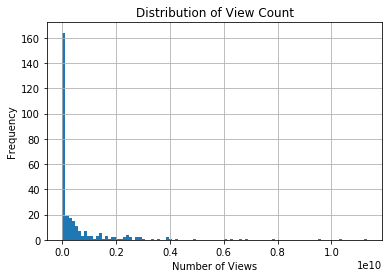

In [8]:
DF.hist(column = 'viewCount', bins=100)
plt.title(label='Distribution of View Count')
plt.xlabel(xlabel='Number of Views')
plt.ylabel(ylabel='Frequency');

Here we see the same thing as with subscriber count; there are a lot of channels that do not have a lot of views, even though we are coming from a network that has some channels that have over 1 billion views.

In [ ]:
fig = network_graphs.plotly_network_graph(G, "Connections", "Corridor Digital's Featured Channels (distance = 3)")
fig # Interactive version of the figure for notebooks

Here we see Corridor Digital's network at a distance of 3 or less away. The colors represent the number of outgoing connections from each node. Those with high values (yellow) feature more channels than those with lower values (blue).

In [ ]:
# Show figure for GitHub
fig.show("svg")

In [ ]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital 3-distance Featured Network')
fig

Here we again see Corridor Digital's network at a distance of 3 or less. In this case the colors represent the distance from our channel origins. Blue represents origin, ligh blue represents 1 channels away, green represents 2 channels away, and yellow represents 3 channels away.

It could be possible for a channel that is 3 channels away from Corridor Digital to then reference one of the Corridor channels back, but this would not change their distance, as going *from* a Corridor Channel *to* that other channel, required three steps to crawl to that channel. Directionality in this case matters.

In [ ]:
# Show figure for GitHub
fig.show("svg")

## Page Rank, In-Degree centrality, Betweeness Centrality, and In-Degree value

In [ ]:
page_rank_series = pd.Series(data = network_graphs.simple_page_rank(G), index = list(G.nodes().keys()))
DF['page_rank'] = DF['id'].map(lambda x:page_rank_series[x])

betweenness_dict = nx.betweenness_centrality(G)
DF['betweenness_centrality'] = DF['id'].map(lambda x:betweenness_dict[x])

in_degree_centrality_dict = nx.in_degree_centrality(G)
DF['in_degree_centrality'] = DF['id'].map(lambda x:in_degree_centrality_dict[x])

in_degree_dict = {node:G.in_degree()[node] for node in G.nodes()}
DF['in_degree'] = DF['id'].map(lambda x:in_degree_dict[x])

degree_dict = {node:G.degree()[node] for node in G.nodes()}
DF['degree'] = DF['id'].map(lambda x:degree_dict[x])

FEATURES = ['title','featuredChannelsCount','degree','in_degree','betweenness_centrality','in_degree_centrality','page_rank','subscriberCount','viewCount','id']

### Sort channels by page rank

Page rank is a relative measure of importance for a specific channel with the network. 

In [ ]:
DF.boxplot(column='page_rank')
plt.title("Boxplot of Simple Page Rank");

In [ ]:
DF[FEATURES].sort_values(
    'page_rank', ascending=False).head(8)

In [ ]:
sorted_pgrank_list = list(DF[FEATURES].sort_values(
    'page_rank', ascending=False).head(8)['id'])

Lets take a look at these channels listed on the graph

In [ ]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital 3-distance Featured Network',
                            display_list=sorted_pgrank_list)
fig
fig.show('svg')

### Sort channels by betweenness centrality.

Betweenness centrality is a measure of connectivity for a node in a network. A higher betweenness centrality implies that the node is a critical pathway for other nodes to connect across the graph.

In [ ]:
DF.boxplot(column='betweenness_centrality');

In [ ]:
DF[FEATURES].sort_values(
    'betweenness_centrality', ascending=False).head(8)

In [ ]:
sorted_btwn_list = list(DF[FEATURES].sort_values(
    'betweenness_centrality', ascending=False).head(8)['id'])

In [ ]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital 3-distance Featured Network',
                            display_list=sorted_btwn_list)
fig
fig.show('svg')

### Sort channels by in_degree centrality.

In degree centrality is a measure of a nodes importance as a reference from other channels. A high in degree centrality value implies that the node is highly referenced by other channels within this network.

In [ ]:
DF.boxplot(column='in_degree_centrality');

In [ ]:
DF[FEATURES].sort_values(
    'in_degree_centrality', ascending=False).head(8)

Lets also look at the distribution of in degree centrality values.

In [ ]:
sorted_indeg_list = list(DF[FEATURES].sort_values(
    'in_degree_centrality', ascending=False).head(8)['id'])

In [ ]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital 3-distance Featured Network',
                            display_list=sorted_indeg_list)
fig.show('svg')

## Strongly Connected Components

Since this graph is a directional graph, and not all references exist in both directions. It is possible to travel through the graph of channels and not be able to return. 

Strongly connected components are portions of the graph that allows you to return to all other nodes in the graph.

In [ ]:
# Create a list of strongly connected components
scc_list = [scc for scc in nx.strongly_connected_components(G)]

# Grab the largest strongly connected component
largest_scc_index = [i for i,cn in enumerate(scc_list) if len(cn) == max([len(cnn) for cnn in scc_list])][0]

# Graph out the subgraph for the largest subset of strongly connected components
H = G.subgraph(list(scc_list[largest_scc_index]))

Plot of our subgraph of strongly connected components

In [ ]:
#network_graphs.graph_nx_graph(H)
fig = network_graphs.plotly_network_graph(H, 
                                          'Distance', 
                                          title='Strongly Connected Subgr

Here we see that the majority of the bottom left of the graph is excluded. Meaning while there were references going from the Corridor community to Rooster Teeth, Slow Mo Guys, Hulu, and etc. There did not exist a path referencing anyone in the Corridor community (at least within a distance of three from Corridor), completely separating the graph.

In [ ]:
fig.show('svg')

In [ ]:
fig = network_graphs.plotly_network_graph(H, 'Connections')
fig

In [ ]:
fig.show('svg')